# H2O AutoML Binary Classification Demo

This is a [Jupyter](https://jupyter.org/) Notebook. When you execute code within the notebook, the results appear beneath the code. To execute a code chunk, place your cursor on the cell and press *Shift+Enter*. 

### Start H2O

Import the **h2o** Python module and `H2OAutoML` class and initialize a local H2O cluster.

In [21]:
import h2o
import pandas
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,19 mins 58 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.7
H2O_cluster_version_age:,14 days and 49 minutes
H2O_cluster_name:,root
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,701 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


### Load Data

For the AutoML binary classification demo, we use a subset of the [Product Backorders](https://www.kaggle.com/tiredgeek/predict-bo-trial/data) dataset.  The goal here is to predict whether or not a product will be put on backorder status, given a number of product metrics such as current inventory, transit time, demand forecasts and prior sales.

In [3]:
# Use local data file or download from GitHub
import os
docker_data_path = "/home/h2o/data/automl/product_backorders.csv"
if os.path.isfile(docker_data_path):
  data_path = docker_data_path
else:
  data_path = "https://github.com/h2oai/h2o-tutorials/raw/master/h2o-world-2017/automl/data/product_backorders.csv"


# Load data into H2O
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


For classification, the response should be encoded as categorical (aka. "factor" or "enum"). Let's take a look.

In [4]:
df.describe()

Rows:19053
Cols:23




,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
type,int,int,int,int,int,int,int,int,int,int,int,int,enum,int,real,real,int,enum,enum,enum,enum,enum,enum
mins,1111620.0,-1440.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,-99.0,-99.0,0.0,,,,,,
mean,2059552.760562641,376.36702881436,7.706036161335186,48.27234556237865,182.91082769117713,344.7398309977432,497.79242114102783,56.11887891670602,168.53445651603428,333.5321996535978,504.2553928515193,48.84070750013122,,2.3114995013908572,-6.519833622001783,-6.053935338266942,0.8917755734005145,,,,,,
maxs,3284775.0,730722.0,52.0,170920.0,479808.0,967776.0,1418208.0,186451.0,550609.0,1136154.0,1759152.0,85584.0,,13824.0,1.0,1.0,1440.0,,,,,,
sigma,663337.6456498676,7002.071628662681,6.7786650721241895,1465.9992102068286,4304.865591970628,8406.062155159243,12180.570042918358,1544.2177775482564,4581.3400802215065,9294.566153218973,14184.145395653624,968.7738680675268,,110.24106014611986,25.975138766871876,25.184497150032538,23.03334541733879,,,,,,
zeros,0,1858,121,15432,12118,11136,10604,10278,8022,6864,6231,9909,,18601,474,401,18585,,,,,,
missing,0,0,1078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1113121.0,0.0,8.0,1.0,6.0,6.0,6.0,0.0,4.0,9.0,12.0,0.0,No,1.0,0.9,0.89,0.0,No,No,No,Yes,No,Yes
1,1113268.0,0.0,8.0,0.0,2.0,3.0,4.0,1.0,2.0,3.0,3.0,0.0,No,0.0,0.96,0.97,0.0,No,No,No,Yes,No,Yes
2,1113874.0,20.0,2.0,0.0,45.0,99.0,153.0,16.0,42.0,80.0,111.0,10.0,No,0.0,0.81,0.88,0.0,No,No,No,Yes,No,Yes


We will notice that the response column, `"went_on_backorder"`, is already encoded as "enum", so there's nothing we need to do here.  If it were encoded as a 0/1 "int", then we'd have to convert the column as follows:  `df[y] = df[y].asfactor()`


Next, let's identify the response & predictor columns by saving them as `x` and `y`.  The `"sku"` column is a unique identifier so we'll want to remove that from the set of our predictors.

In [5]:
y = "went_on_backorder"
x = df.columns
x.remove(y)
x.remove("sku")

## Run AutoML 

Run AutoML, stopping after 10 models.  The `max_models` argument specifies the number of individual (or "base") models, and does not include the two ensemble models that are trained at the end.

In [6]:
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(x = x, y = y, training_frame = df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


*Note: If you see the following error, it means that you need to install the pandas module.*
```
H2OTypeError: Argument `python_obj` should be a None | list | tuple | dict | numpy.ndarray | pandas.DataFrame | scipy.sparse.issparse, got H2OTwoDimTable 
``` 

## Leaderboard

Next, we will view the AutoML Leaderboard.  Since we did not specify a `leaderboard_frame` in the `H2OAutoML.train()` method for scoring and ranking the models, the AutoML leaderboard uses cross-validation metrics to rank the models.  

A default performance metric for each machine learning task (binary classification, multiclass classification, regression) is specified internally and the leaderboard will be sorted by that metric.  In the case of binary classification, the default ranking metric is Area Under the ROC Curve (AUC).  In the future, the user will be able to specify any of the H2O metrics so that different metrics can be used to generate rankings on the leaderboard.

The leader model is stored at `aml.leader` and the leaderboard is stored at `aml.leaderboard`.

In [7]:
lb = aml.leaderboard

Now we will view a snapshot of the top models.  Here we should see the two Stacked Ensembles at or near the top of the leaderboard.  Stacked Ensembles can almost always outperform a single model.

In [8]:
lb.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20200804_180221,0.950875,0.18191,0.74971,0.149404,0.227568,0.0517873
StackedEnsemble_BestOfFamily_AutoML_20200804_180221,0.950322,0.183105,0.746117,0.151635,0.228331,0.0521349
GBM_4_AutoML_20200804_180221,0.948844,0.173579,0.739163,0.157246,0.22659,0.051343
GBM_3_AutoML_20200804_180221,0.946825,0.177091,0.733092,0.147716,0.22862,0.0522671
XGBoost_3_AutoML_20200804_180221,0.945963,0.176662,0.736605,0.150975,0.228394,0.0521638
GBM_2_AutoML_20200804_180221,0.945111,0.179764,0.727168,0.166382,0.230232,0.0530067
GBM_5_AutoML_20200804_180221,0.945026,0.17789,0.731021,0.14231,0.229819,0.0528166
XGBoost_1_AutoML_20200804_180221,0.944056,0.181315,0.726937,0.170148,0.229817,0.0528157
XGBoost_2_AutoML_20200804_180221,0.943926,0.180467,0.720383,0.153593,0.229968,0.0528851
GBM_1_AutoML_20200804_180221,0.942464,0.183815,0.720289,0.15893,0.232004,0.0538257


To view the entire leaderboard, specify the `rows` argument of the `head()` method as the total number of rows:

## Ensemble Exploration

To understand how the ensemble works, let's take a peek inside the Stacked Ensemble "All Models" model.  The "All Models" ensemble is an ensemble of all of the individual models in the AutoML run.  This is often the top performing model on the leaderboard.

In [9]:
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20200804_180221,0.950875,0.18191,0.74971,0.149404,0.227568,0.0517873
StackedEnsemble_BestOfFamily_AutoML_20200804_180221,0.950322,0.183105,0.746117,0.151635,0.228331,0.0521349
GBM_4_AutoML_20200804_180221,0.948844,0.173579,0.739163,0.157246,0.22659,0.051343
GBM_3_AutoML_20200804_180221,0.946825,0.177091,0.733092,0.147716,0.22862,0.0522671
XGBoost_3_AutoML_20200804_180221,0.945963,0.176662,0.736605,0.150975,0.228394,0.0521638
GBM_2_AutoML_20200804_180221,0.945111,0.179764,0.727168,0.166382,0.230232,0.0530067
GBM_5_AutoML_20200804_180221,0.945026,0.17789,0.731021,0.14231,0.229819,0.0528166
XGBoost_1_AutoML_20200804_180221,0.944056,0.181315,0.726937,0.170148,0.229817,0.0528157
XGBoost_2_AutoML_20200804_180221,0.943926,0.180467,0.720383,0.153593,0.229968,0.0528851
GBM_1_AutoML_20200804_180221,0.942464,0.183815,0.720289,0.15893,0.232004,0.0538257


In [24]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

Examine the variable importance of the metalearner (combiner) algorithm in the ensemble.  This shows us how much each base learner is contributing to the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM. 

In [25]:
metalearner.coef_norm()

{'Intercept': -2.9328866406340395,
 'GBM_4_AutoML_20200804_180221': 0.25831827630722637,
 'GBM_3_AutoML_20200804_180221': 0.0,
 'XGBoost_3_AutoML_20200804_180221': 0.22676599832917094,
 'GBM_2_AutoML_20200804_180221': 0.0,
 'GBM_5_AutoML_20200804_180221': 0.15456670853334348,
 'XGBoost_1_AutoML_20200804_180221': 0.29948392026454124,
 'XGBoost_2_AutoML_20200804_180221': 0.22824374604132683,
 'GBM_1_AutoML_20200804_180221': 0.10956485624867902,
 'DRF_1_AutoML_20200804_180221': 0.5104949280458281,
 'GLM_1_AutoML_20200804_180221': 0.05218316835950639}

We can also plot the base learner contributions to the ensemble.

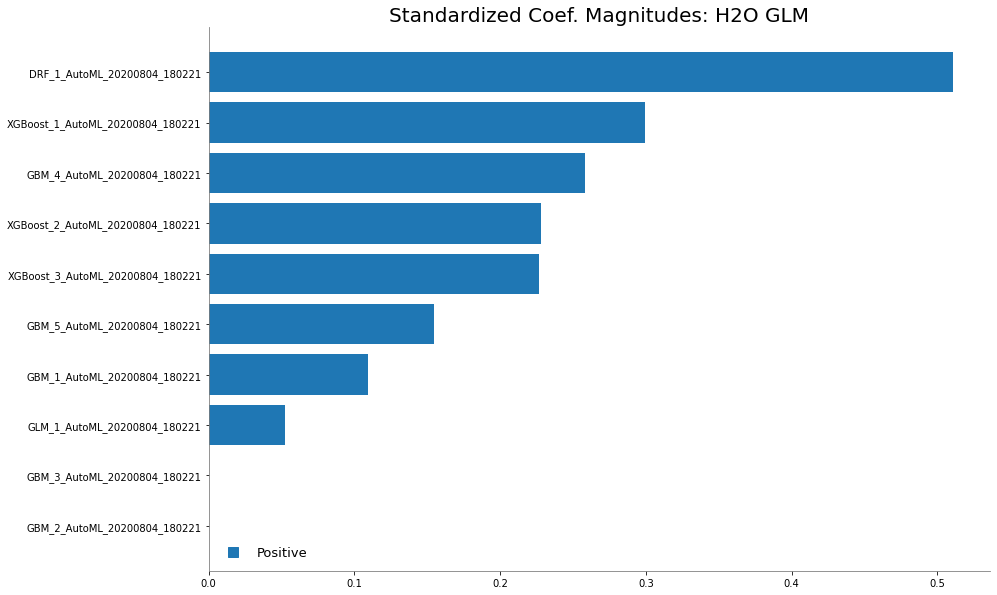

In [27]:
%matplotlib inline
metalearner.std_coef_plot()

## Save Leader Model

There are two ways to save the leader model -- binary format and MOJO format.  If you're taking your leader model to production, then we'd suggest the MOJO format since it's optimized for production use.

In [28]:
h2o.save_model(aml.leader, path = "./product_backorders_model_bin")

'/opt/product_backorders_model_bin/StackedEnsemble_AllModels_AutoML_20200804_180221'

In [29]:
aml.leader.download_mojo(path = "./")

'/root/h2o/h2o_venv/StackedEnsemble_AllModels_AutoML_20200804_180221.zip'

## Predict Data

In [44]:
df.head()

sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1.11312e+06,0,8,1,6,6,6,0,4,9,12,0,No,1,0.9,0.89,0,No,No,No,Yes,No,Yes
1.11327e+06,0,8,0,2,3,4,1,2,3,3,0,No,0,0.96,0.97,0,No,No,No,Yes,No,Yes
1.11387e+06,20,2,0,45,99,153,16,42,80,111,10,No,0,0.81,0.88,0,No,No,No,Yes,No,Yes
1.11422e+06,0,8,0,9,14,21,5,17,36,43,0,No,0,0.96,0.98,0,No,No,No,Yes,No,Yes
1.11482e+06,0,12,0,31,31,31,7,15,33,47,2,No,3,0.98,0.98,0,No,No,No,Yes,No,Yes
1.11545e+06,55,8,0,216,360,492,30,108,275,340,51,No,0,0,0,0,No,No,Yes,Yes,No,Yes
1.11562e+06,-34,8,0,120,240,240,83,122,144,165,33,No,0,1,0.97,34,No,No,No,Yes,No,Yes
1.11645e+06,4,9,0,43,67,115,5,22,40,58,4,No,0,0.69,0.68,0,No,No,No,Yes,No,Yes
1.11683e+06,2,8,0,4,6,9,1,5,6,9,2,No,0,1,0.95,0,No,No,No,Yes,No,Yes
1.11687e+06,-7,8,0,56,96,112,13,30,56,76,0,No,0,0.97,0.92,7,No,No,No,Yes,No,Yes


In [72]:
test_data = [[
    1.11312e+06, # first row data, should be yes (went_on_backorder)
    0,
    8,
    1,
    6,
    6,
    6,
    0,
    4,
    9,
    12,
    0,
    "No",
    1,
    0.9,
    0.89,
    0,
    "No",
    "No",
    "No",
    "Yes",
    "No"
]]

test_frame = h2o.H2OFrame(
    column_names = [
        "sku",
        "national_inv",
        "lead_time",
        "in_transit_qty",
        "forecast_3_month",
        "forecast_6_month",
        "forecast_9_month",
        "sales_1_month",
        "sales_3_month",
        "sales_6_month",
        "sales_9_month",
        "min_bank",
        "potential_issue",
        "pieces_past_due",
        "perf_6_month_avg",
        "perf_12_month_avg",
        "local_bo_qty",
        "deck_risk",
        "oe_constraint",
        "ppap_risk",
        "stop_auto_buy",
        "rev_stop"
    ],
    python_obj=test_data
)

test_frame.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
1.11312e+06,0,8,1,6,6,6,0,4,9,12,0,No,1,0.9,0.89,0,No,No,No,Yes,No


In [73]:

preds = aml.predict(test_frame)


stackedensemble prediction progress: |████████████████████████████████████| 100%


In [69]:
preds.head()

predict,No,Yes
Yes,0.203162,0.796838
